<a href="https://colab.research.google.com/github/davidnt13/MetaboliteML/blob/master/AcetylRFTrainOnNonMetabolite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 26.1 MB/s eta 0:00:00


In [3]:
import pandas as pd #data manipulation
from rdkit import Chem #Chemistry
from rdkit.Chem import Descriptors
import numpy as np #matrix algebra
from sklearn.model_selection import train_test_split #ML trainining
from sklearn.metrics import r2_score, mean_squared_error #ML stats
import seaborn as sns #Plotting
import matplotlib.pyplot as plt

In [4]:
dfTrain = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Reker Lab ML/Acetylcholinesterase ML Work/training_data.csv")
dfTest = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Reker Lab ML/Acetylcholinesterase ML Work/test_data.csv")

In [5]:
smiles_stringsTrain = dfTrain['SMILES'].tolist()
smiles_stringsTest = dfTest['SMILES'].tolist()

In [6]:
smilesTrain = [Chem.MolFromSmiles(mol) for mol in smiles_stringsTrain]
smilesTest = [Chem.MolFromSmiles(mol) for mol in smiles_stringsTest]

In [7]:
descrsTrain = [Descriptors.CalcMolDescriptors(mol) for mol in smilesTrain]
descrsTest = [Descriptors.CalcMolDescriptors(mol) for mol in smilesTest]
df2Train = pd.DataFrame(descrsTrain)
df2Test = pd.DataFrame(descrsTest)

In [12]:
train_X = df2Train.dropna(axis = 1)
train_y = dfTrain.pIC50
test_X = df2Test.dropna(axis = 1)
test_y = dfTest.pIC50

common_columns = train_X.columns.intersection(test_X.columns)
train_X = train_X[common_columns]
test_X = test_X[common_columns]

In [13]:
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [14]:
regressor = RandomForestRegressor(n_estimators=10, random_state=1)

from sklearn.model_selection import KFold, cross_val_score

k_folds = KFold(n_splits = 10, shuffle = True, random_state = 1)

scores = cross_val_score(regressor, train_X, train_y, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.66105474 0.61460166 0.57557775 0.61050606 0.66356625 0.63573463
 0.63561672 0.57680211 0.52461777 0.60798183]
Average CV Score:  0.6106059521962858
Number of CV Scores used in Average:  10


In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error

import numpy as np
import pandas as pd

# Number of MC CV cycles
mc_cv = 20

# Number of CV folds for hyperparameter tuning:
hyper_cv = 10

# Fraction of data to use as test set:
test_frac = 0.3

# Name of file to write all predictions to:
predictions_filename = 'RFSwap_predictions.csv'

# Variables to save model performance statistics:
r2_sum = 0
rmsd_sum = 0
bias_sum = 0
sdep_sum = 0

# List to save individual predictions from the models trained from
# each train/test split:
all_preds = np.empty((mc_cv, len(test_y)), dtype=float)
all_preds[:] = np.nan

# Initialise train test split:
#train_test_split = ShuffleSplit(mc_cv, test_size=test_frac)
train_test_split = kFold(mc_cv, test_size=test_frac)

# Monte Carlo CV:
for n, [train_idx, test_idx] in enumerate(train_test_split.split(test_X)):

    # Separate data into training and test sets:
    # Have to use ".iloc" if x and y are pandas DataFrames and Series objects,
    # if they are just numpy arrays remove ".iloc".
    x_train = train_X.iloc[train_idx]
    x_test = train_X.iloc[test_idx]
    y_train = train_y.iloc[train_idx]
    y_test = train_y.iloc[test_idx]

    # Centre and scale all x features to have mean=0 and var=1:
    # (Not required for random forest, but important for some other ML methods)
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    rf = RandomForestRegressor()

    # Train RF model:
    rf.fit(x_train, y_train)

    # Use trained RF model to predict y data for the test set:
    y_pred = rf.predict(x_test)

    # Assess performace of model based on predictions:

    # Coefficient of determination
    r2 = r2_score(y_test, y_pred)
    # Root mean squared error
    rmsd = mean_squared_error(y_test, y_pred)**0.5
    # Bias
    bias = np.mean(y_pred - y_test)
    # Standard deviation of the error of prediction
    sdep = np.mean(((y_pred - y_test) - np.mean(y_pred - y_test))**2)**0.5

    # Save running sum of results:
    r2_sum += r2
    rmsd_sum += rmsd
    bias_sum += bias
    sdep_sum += sdep

    # Save individual predictions:
    all_preds[n,test_idx] = y_pred

# Average results over resamples:
r2_av = r2_sum/mc_cv
rmsd_av = rmsd_sum/mc_cv
bias_av = bias_sum/mc_cv
sdep_av = sdep_sum/mc_cv


In [ ]:
# Name of file to write results to:
results_filename = 'RFSwap_results.txt'

# Write average results to a file:
results_file = open(results_filename, 'w')
results_file.write('r2: {:.3f}\n'.format(r2_av))
results_file.write('rmsd: {:.3f}\n'.format(rmsd_av))
results_file.write('bias: {:.3f}\n'.format(bias_av))
results_file.write('sdep: {:.3f}\n'.format(sdep_av))
results_file.close()

# Save all individual predictions to file:
predictions_file = open(predictions_filename, 'w')
# Write header:
predictions_file.write(','.join([str(i) for i in train_y.index]) + '\n')
# Write individual predictions from each MC CV cycle:
for n in range(mc_cv):
    predictions_file.write(','.join([str(p) if not np.isnan(p) else '' for p in all_preds[n]]) + '\n')
predictions_file.close()

In [22]:
rf = RandomForestRegressor()
rf.fit(train_X, train_y)
y_pred = rf.predict(test_X)
# Coefficient of determination
r2 = r2_score(test_y, y_pred)
# Root mean squared error
rmsd = mean_squared_error(test_y, y_pred)**0.5
# Bias
bias = np.mean(y_pred - test_y)
# Standard deviation of the error of prediction
sdep = np.mean(((y_pred - test_y) - np.mean(y_pred - test_y))**2)**0.5

r2: 0.13083256339751403
rmsd: 1.0928201095074404
bias: 0.13922944444444418
sdep: 1.0839146431078166
Slope of Line of Best Fit: 0.12712692602110962


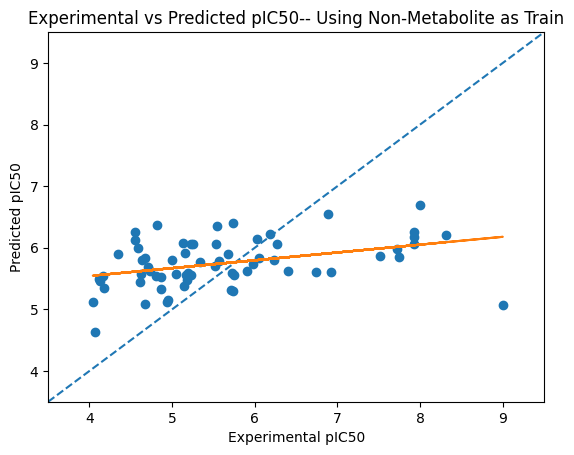

In [25]:
print(f"r2: {r2}")
print(f"rmsd: {rmsd}")
print(f"bias: {bias}")
print(f"sdep: {sdep}")

plt.scatter(test_y, y_pred)
a, b = np.polyfit(test_y, y_pred, 1)
print(f"Slope of Line of Best Fit: {a}")

xvals = np.linspace(3.5, 9.5, 100)
yvals = xvals
plt.plot(xvals, yvals, '--')

plt.plot(test_y, a*test_y+b)
plt.xlabel("Experimental pIC50")
plt.ylabel("Predicted pIC50")
plt.title("Experimental vs Predicted pIC50-- Using Non-Metabolite as Train")
plt.xlim(3.5, 9.5)
plt.ylim(3.5, 9.5)
plt.show()

In [ ]:
initPredict = pd.read_csv("RF_predictions(1).csv")
initPredict = initPredict.transpose()
avg = initPredict.mean(skipna=True)
print(avg)

0     6.159999
1     6.150591
2     6.191134
3     6.143118
4     6.173409
5     6.154277
6     6.181245
7     6.140624
8     6.183487
9     6.206242
10    6.157609
11    6.168836
12    6.191084
13    6.162066
14    6.169873
15    6.182678
16    6.155734
17    6.141014
18    6.168479
19    6.165481
dtype: float64
